# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [1]:
names = {'student_1': "Marshall Cooper",
        'student_2': "Andrea Piccione"}

sciper = {'student_1': 299656, 
          'student_2': 294045}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy
import pickle

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping


def getRawDataFromFile(datapath="../data/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [2]:
import random

# Loading data
conversations = getRawDataFromFile()

# Sample 2 conversations
random.choices(conversations, k=2)

[['hello , what do you do for fun ?',
  'hi . i collect toys that wear small rain coats . you ?',
  'i am too busy with work . i am diner chef , and run my own cupcake store .',
  'then you are very busy . i hear voices .',
  'too busy i never make it anywhere on time . what kind of voices ?',
  '2 women . they sound young .',
  'maybe you are hearing me when i sing opera in the shower . do the voices sing ?',
  'no they do not sing . they scream a lot .',
  'i usually only hear screaming voices in my head while i am trying to fall asleep .',
  'they argue with each other . i argue with myself .',
  'what do they and you argue about ? i often argue about the best cupcake flavors .',
  'everything . who is right , who is wrong .',
  'well , if it is ever about cupcakes , diner food , or shower songs , drop me a line .',
  'i love cakes that are a mystery flavor .',
  'mystery cakes and meat , and even meat cakes are really the best , i agree .',
  'my neighbor has a pool . their pool bo

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** Zipf's law asserts an inverse proportional relationship between frequency and word rank within a natural language vocabulary. The evidence of this particular relation (as opposed to some other shrinking distribution that is not "Zipfian") is shown by the linearization of such a relation under log-log axes. In our log-log plot we see what resembles a line, although we note that it is not perfectly linear. It is close enough that we consider this ordering to align with Zipf's law. This relation has the property that we can omit infrequent vocabulary while retaining much of the overall data.

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** 7080



In [80]:
# Get word-count dictionary
from collections import Counter
dictionary = Counter()
for c in conversations:
    for s in c:
        dictionary.update(s.split(' '))

<BarContainer object of 75 artists>

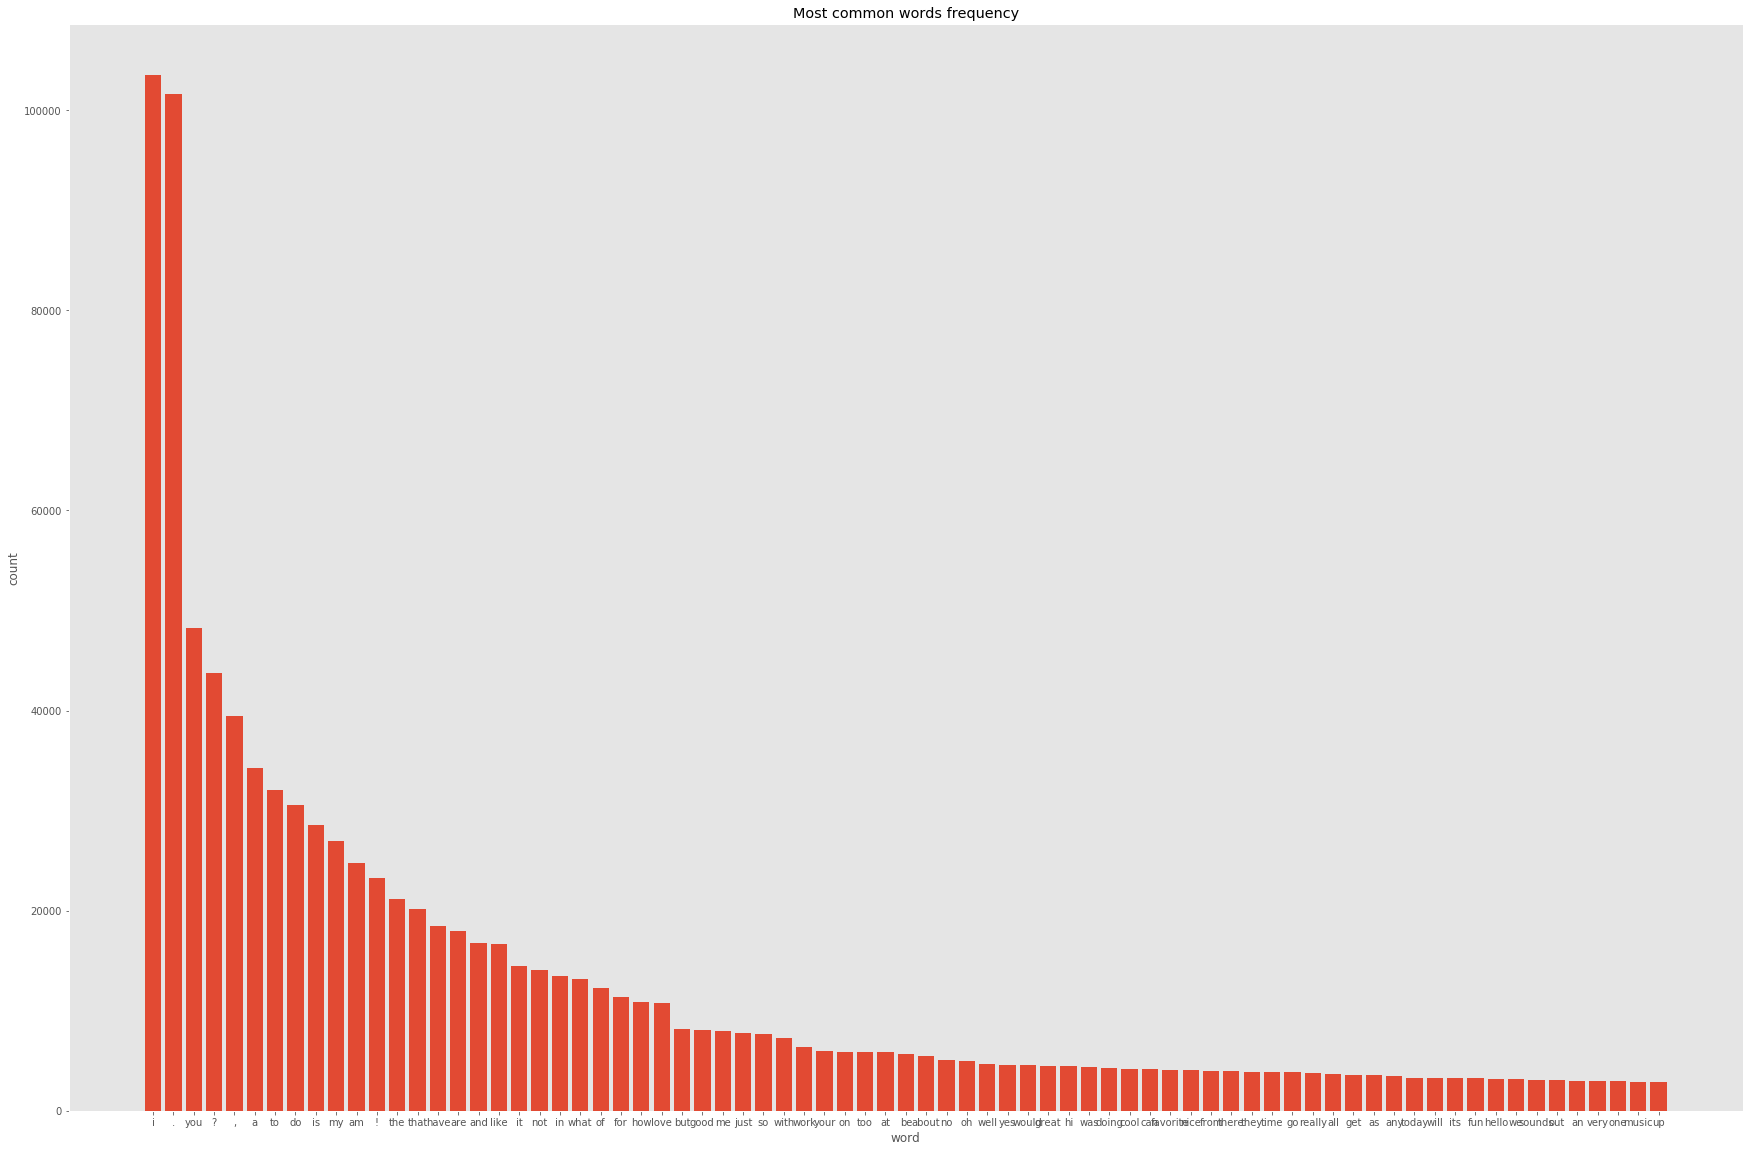

In [86]:
# Get most frequent words
frequent_words = dictionary.most_common(75)

# Get count and words separately
keys = [i[0] for i in frequent_words]
values = [i[1] for i in frequent_words]

# Plotting
plt.figure(figsize=(30,20))
plt.title("Most common words frequency")
plt.xlabel("word")
plt.ylabel("count")
plt.bar(keys, values)

<BarContainer object of 75 artists>

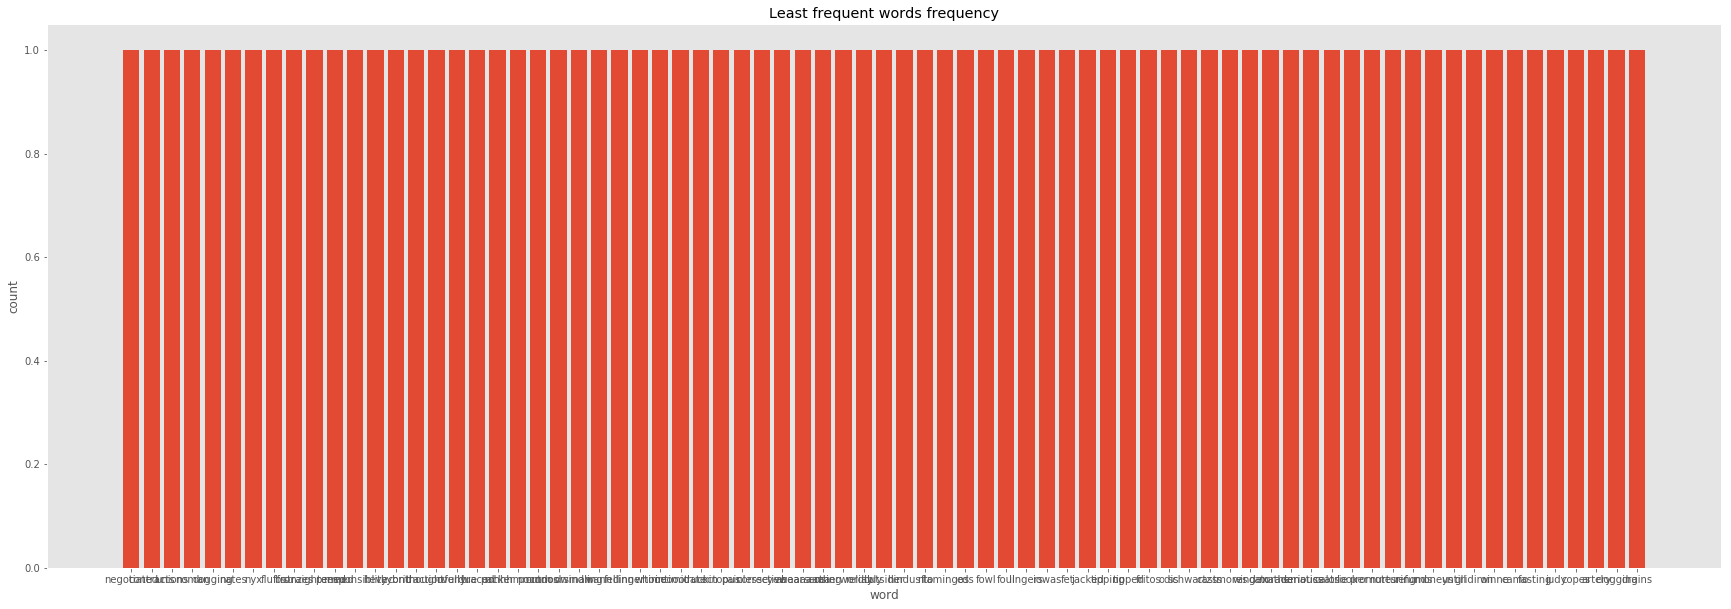

In [92]:
# Get least frequent words
unfrequent_words = dictionary.most_common()[-76:-1]

# Get words and counts separately
keys = [i[0] for i in unfrequent_words]
values = [i[1] for i in unfrequent_words]

# Plotting
plt.figure(figsize=(30,10))
plt.title("Least frequent words frequency")
plt.xlabel("word")
plt.ylabel("count")
plt.bar(keys, values)

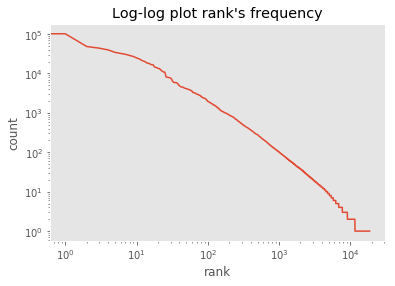

In [94]:
# Get count
values = [i[1] for i in dictionary.most_common()]

# Generate log-log plot
plt.title("Log-log plot rank's frequency")
plt.xlabel("rank")
plt.ylabel("count")
plt.loglog(range(len(dictionary.most_common())), values)

In [10]:
# Get number of words that appear only once
ones = [w for w in dictionary if dictionary[w] == 1]
print("Number of words appearing only ones: " + str(len(ones)))

Number of words appearing only ones: 7080


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: 18673 words were pruned -> 1007 words, approximately 94% reduction.

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: 131424 sentences -> 50793 sentences including only words that appear more than 100 times.

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: In the most extreme case, we can consider a word that only appears one time as having only a single transition (to the word that appears after it) that it can teach the learner. This should be easy to learn for the model, as it will always incur little loss for predicting that transition with high certainty, but this will not generalize well since the word may have more diverse usage that is not witnessed in the training data. In short, we expect that rare words should improve training performance (loss/accuracy) but worsen generalization, and we remove sentences containing them because we want the model to generalize well.

In [5]:
# Declare N and threshold of remaining sentences
threshold = 50000
# Update dictionary
words = dictionary
filtered = conversations
N = 0
prev = filtered
pruned = dict([(i, words[i]) for i in words if words[i]>N])
total = sum([len(i) for i in filtered])
while(total>threshold):
    prev = (filtered, pruned, N)
    N += 50
    pruned = dict([(i, words[i]) for i in words if words[i]>N])
    filtered = [i for i in [[sentence for sentence in conversation if all([word in pruned.keys() for word in sentence.split(' ')])] for conversation in conversations] if i!=[]]
    total = sum([len(i) for i in filtered])
    print("Filtering N = {0} : {1} sentences remaining N.".format(N, total))

    
filtered, pruned, N = prev
total = sum([len(i) for i in filtered])
print("Using N = {0}".format(N))
print("{0} words originally, reduced to {1}: {2}% reduction.".format(len(words), len(pruned), int(100*(1-(len(pruned)/len(words))))))

Filtering N = 50 : 66500 sentences remaining N.
Filtering N = 100 : 50793 sentences remaining N.
Filtering N = 150 : 41527 sentences remaining N.
Using N = 100
18673 words originally, reduced to 1007: 94% reduction.


### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [6]:
## Generate tokens
tokens = ['PADD', 'START', 'END'] + list(pruned.keys())

## Tokenize the input
tokenized = [[[tokens.index(word) for word in ['START'] + sentence.split(' ') + ['END']] for sentence in conversation] for conversation in filtered]

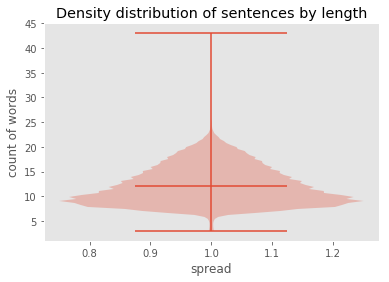

In [95]:
## Count lengths of each sentence
lens = Counter()
[lens.update([len(sentence) for sentence in conversation]) for conversation in tokenized]

## Plots
plt.title("Density distribution of sentences by length")
plt.xlabel("spread")
plt.ylabel("count of words")

_ = plt.violinplot([i for i in lens.elements()], showmeans=True)

In [8]:
## Visually it appears as if 25 is a reasonable cutoff
maxlen = 25
## Generate padded sequences; create a flat representation as well
padded = [pad_sequences(conversation, maxlen, padding="post", truncating="post") for conversation in tokenized]
padded_flat = [sentence for conversation in padded for sentence in conversation]
padded_flat[:5]

[array([ 1,  7, 20, 21, 22, 23, 19, 24, 25, 26, 27, 28, 29, 30, 19,  2,  0,
         0,  0,  0,  0,  0,  0,  0,  0], dtype=int32),
 array([ 1, 40, 25, 45, 19, 15,  7, 46, 47, 29, 48, 35, 49, 27, 50,  9,  2,
         0,  0,  0,  0,  0,  0,  0,  0], dtype=int32),
 array([ 1, 56, 25, 57, 29, 52, 14, 55,  9,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0], dtype=int32),
 array([ 1,  3,  4,  5,  6,  7,  8, 67,  9,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0], dtype=int32),
 array([ 1, 10, 11, 80, 49, 81, 28, 82, 83, 56,  6,  7, 84, 14,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)]

In [9]:
## Randomly select sentences to recover. Use tokens[i] for each integer i in the padded representation
to_recover = [padded_flat[i] for i in np.random.randint(0, len(conversations),size=2)]
[" ".join([tokens[i] for i in sentence if i>2]) for sentence in to_recover]

['i play basketball for a professional basketball team .',
 'me too . how are you ?']

### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [10]:
import pickle

#save
with open("data.pkl", "wb") as file:
    pickle.dump([filtered, words, tokens], file)
    
#load
with open("data.pkl", "rb") as file:
    [filtered, words, tokens] = pickle.load(file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** In theory, encountering 'PADD' at any given time step should predict a subsequent 'PADD' with high certainty, since all instances of 'PADD' lead to 'PADD' within the dataset (this is because we chose to 'post' pad the sequences). In practice, in utilizing the model, we terminate generation of new words if we encounter 'END', meaning that we will never use the model to generate transition probabilities following a 'PADD' time step, even though the model should compute these.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer** We input a (n, maxlen-1) matrix to our model, where n is the number of sentences we want to process, and maxlen-1 is determined as all time steps of each sequence, post-padded, up to the penultimate time step. It will predict a (n, maxlen-1, d) tensor, where d is size of the vocabulary. The interpretation for this output tensor is that for each sentence and time step it is producing the transition probabilities for the upcoming timestep. For example, the d-dimension distribution at (1, 4, :) predicts the probability distribution of the 5th word in the first sentence.

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: LSTM and GRU yield nearly equivalent validation accuracy, both higher than SimpleRNN, with LSTM slightly winning out. SimpleRNN is the fastest learner.

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: Each model seems to overfit after a certain epoch (around 10-15 for each, indicated by validation loss plots). This could be explained by the fact that each epoch represents a pass of the data through the learning algorithm, which means that at high epochs, our model gains the ability to 'memorize' the training data to some degree.

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: Applying some type of rule-based augmentation of the dataset could decrease overfitting by adding more conflicting examples for the model to try to learn. An example of this kind of augmentation would be generating new sentences by interchanging adjectives in sentences. This could emulate the practice of producing translated images to augment an image dataset, except for textual data.

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: Dropout could be used to decrease overfitting.

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: Running for fewer epochs (or using EarlyStopping) should decrease overfitting.

In [31]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [32]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [33]:
## Let X be the list of sentences: NxM where N is number of sentence, M is max length of pad
X = np.array(padded_flat)
## Let T be the one-hot encoding of X: NxMxD where D is the length of the vocabulary
## T[n,m,d] = 1 only when mth word of the nth sentence is the dth word of the vocabulary
T = np.zeros(X.shape + (len(tokens),))
for i, sentence in enumerate(X):
    for j, word in enumerate(sentence):
        T[i,j,word] = 1

In [28]:
def load_custom_model(model, layers, hidden_size):
    key = model + "_" + str(layers) + "_" + str(hidden_size) + "_" + str(embedding_size)
    
    with open(key+"_log.pkl", "rb") as file:
        model_log = pickle.load(file)
    model = load_model(key)
    return model

In [29]:
def train_custom_model(model, layers, hidden_size, transf_learning=False, early_stop=False):
    
    key = model + "_" + str(layers) + "_" + str(hidden_size) + "_" +str(embedding_size)
    
    I[key] = Input(shape=(maxlen-1,), name="input")
    
    if transf_learning:
        E[key] = Embedding(len(tokens), embedding_size, embeddings_initializer=keras.initializers.Constant(np.load("best_embedding.npy")[0]), mask_zero=True, name="embedding", trainable=False)(I[key])
    else:
        E[key] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")(I[key])
        
    
    H[key] = getattr(keras.layers, model)(hidden_size, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(E[key])
    
    for i in range(2,layers+1):            
        H[key] = getattr(keras.layers, model)(hidden_size, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(H[key]) #... Recurrent layer(s)
        
    R[key] = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(H[key])   #... Readout
    Y[key] = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R[key]) #... Output

    models[key] = Model(inputs = [I[key]], outputs = [Y[key]])
    models[key].compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(),
        metrics=['acc'])
    models[key].summary()
    
    es = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)
    
    print(X[:,:-1].shape, T[:,1:].shape)
    
    if early_stop:
        logs[key] = models[key].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                        epochs=epochs, 
                                        validation_split=validation_split, 
                                        batch_size=batch_size,
                                        callbacks=[es]).history
    else:
        logs[key] = models[key].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                        epochs=epochs, 
                                        validation_split=validation_split, 
                                        batch_size=batch_size).history

    
    
    #save
    with open(key + "_log.pkl", "wb") as file:
        pickle.dump(logs[key], file)
    models[key].save(key)

In [30]:
def plot_learning_curves(history, title):
    
    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title + ": loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()
    
    # Plot accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title + ": accuracy")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.show()

In [17]:
# SimpleRNN
train_custom_model("SimpleRNN", 1, hidden_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           129280    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24, 64)            12352     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 1010)          130290    
Total params: 280,242
Trainable params: 280,242
Non-trainable params: 0
_________________________________________________________________
(50793, 24) (50793, 24, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [==============================] 

In [18]:
# LSTM
train_custom_model("LSTM", 1, hidden_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           129280    
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 64)            49408     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 1010)          130290    
Total params: 317,298
Trainable params: 317,298
Non-trainable params: 0
_________________________________________________________________
(50793, 24) (50793, 24, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [==============================] 

In [19]:
# GRU 
train_custom_model("GRU", 1, hidden_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           129280    
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 1010)          130290    
Total params: 304,946
Trainable params: 304,946
Non-trainable params: 0
_________________________________________________________________
(50793, 24) (50793, 24, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [==============================] 

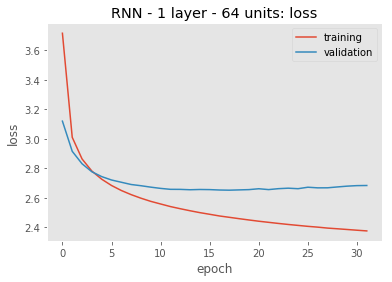

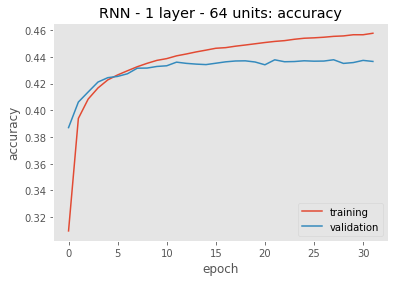

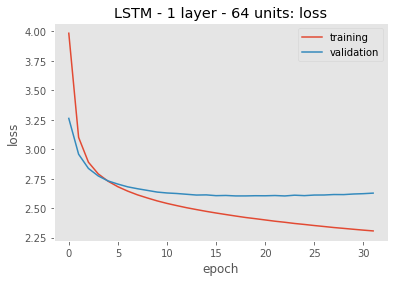

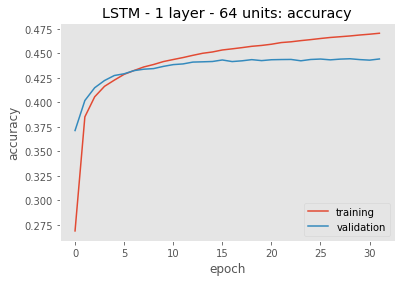

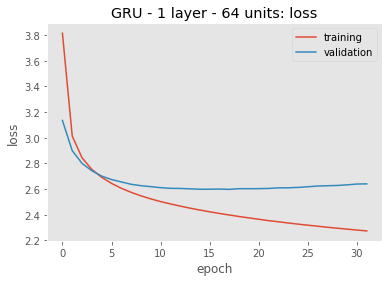

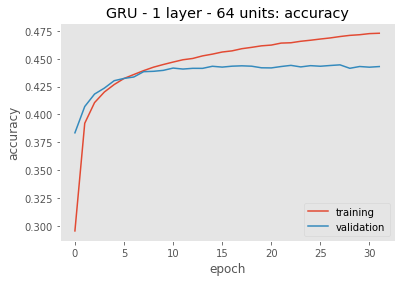

In [20]:
# Plotting learning curves for each of the 3 models
plot_learning_curves(models["SimpleRNN_1_64_128"].history, "RNN - 1 layer - 64 units")
plot_learning_curves(models["LSTM_1_64_128"].history, "LSTM - 1 layer - 64 units")
plot_learning_curves(models["GRU_1_64_128"].history, "GRU - 1 layer - 64 units")

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer** Increasing units (to 128 and to 256) slightly improved accuracy and loss, but at the cost of increased computation and slower performance. Increasing the number of layers actually reduced performance versus the 64 unit single layer model. The behavior of the learning curves are similar in all four models, with training/validation metrics each generally improving over increased epochs until termination of training.

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer** The learning curves of the models do not exhibit long-term overfitting due to training epochs. This can be attributed to using EarlyStopping. One benefit of EarlyStopping is that it produces more generalizable models. One drawback of EarlyStopping is that noise/fluctuations during training can cause premature stopping, which can lead to underfitting.

**Question** What is your best model? Why? [1 pt]

**Answer** Using 256 units in a single layer was, by only a very small margin, our best performing model. For this task, we favor low validation loss as our metric of comparison instead of accuracy, because we feel that low validation loss represents an overall better distribution of transition probabilities.



In [47]:
# Selecting best embedding layer: GRU results in best performance
best_embedding = load_custom_model("GRU", layers=1, hidden_size=64).get_layer("embedding").get_weights()
np.save("best_embedding", best_embedding)

In [35]:
# 64 units
train_custom_model("GRU", 1, hidden_size=64, transf_learning=True, early_stop=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           129280    
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 1010)          130290    
Total params: 304,946
Trainable params: 175,666
Non-trainable params: 129,280
_________________________________________________________________
(50793, 24) (50793, 24, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [==========================

In [40]:
# 128 units
train_custom_model("GRU", 1, hidden_size=128, transf_learning=True, early_stop=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           129280    
_________________________________________________________________
gru_2 (GRU)                  (None, 24, 128)           98688     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           16512     
_________________________________________________________________
output (TimeDistributed)     (None, 24, 1010)          130290    
Total params: 374,770
Trainable params: 245,490
Non-trainable params: 129,280
_________________________________________________________________
(50793, 24) (50793, 24, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [==========================

In [41]:
# 256 units
train_custom_model("GRU", 1, hidden_size=256, transf_learning=True, early_stop=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           129280    
_________________________________________________________________
gru_3 (GRU)                  (None, 24, 256)           295680    
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           32896     
_________________________________________________________________
output (TimeDistributed)     (None, 24, 1010)          130290    
Total params: 588,146
Trainable params: 458,866
Non-trainable params: 129,280
_________________________________________________________________
(50793, 24) (50793, 24, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [==========================

In [42]:
# 2 layers, 64 units
train_custom_model("GRU", 2, hidden_size=64, transf_learning=True, early_stop=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           129280    
_________________________________________________________________
gru_4 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
gru_5 (GRU)                  (None, 24, 64)            24768     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 24, 1010)          130290    
Total params: 329,714
Trainable params: 200,434
Non-trainable params: 129,280
________________________________________________________________

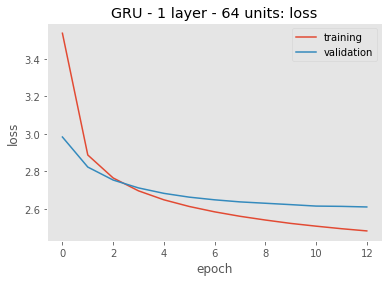

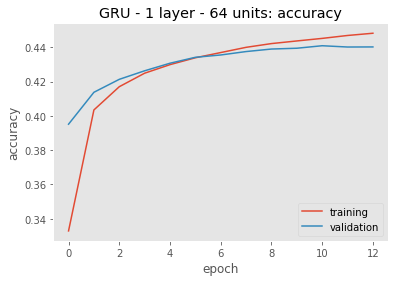

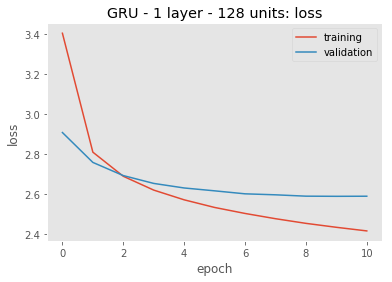

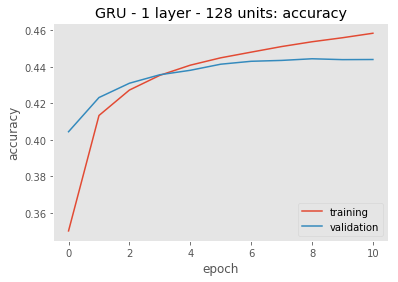

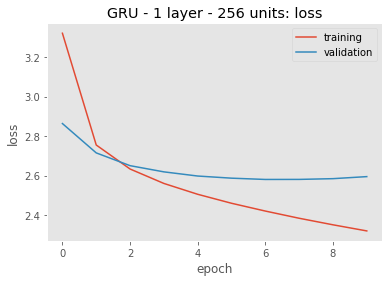

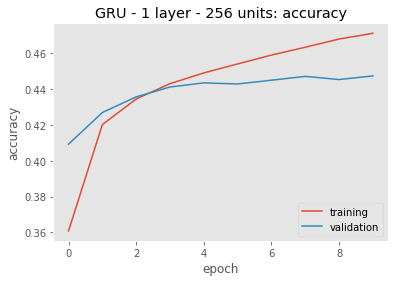

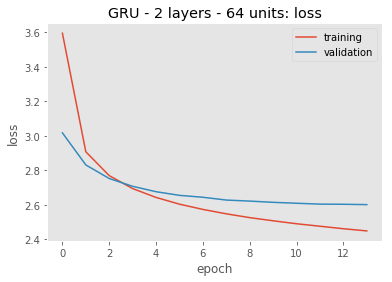

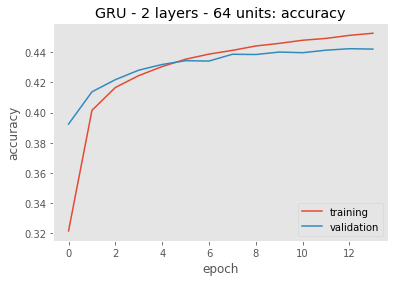

In [43]:
# Plotting learning curves for each of the 4 models
plot_learning_curves(models["GRU_1_64_128"].history, "GRU - 1 layer - 64 units")
plot_learning_curves(models["GRU_1_128_128"].history, "GRU - 1 layer - 128 units")
plot_learning_curves(models["GRU_1_256_128"].history, "GRU - 1 layer - 256 units")
plot_learning_curves(models["GRU_2_64_128"].history, "GRU - 2 layers - 64 units")

In [26]:
# Update best embedding layer: GRU 256 units had the best performance
best_embedding = load_custom_model("GRU", layers=1, hidden_size=256).get_layer("embedding").get_weights()
np.save("best_embedding_2", best_embedding)

In [27]:
models

{'SimpleRNN_1_64_128': <keras.engine.training.Model at 0x7f036eb0d240>,
 'LSTM_1_64_128': <keras.engine.training.Model at 0x7f036e0755f8>,
 'GRU_1_64_128': <keras.engine.training.Model at 0x7f035c1af7b8>,
 'GRU_1_128_128': <keras.engine.training.Model at 0x7f0277a1e710>,
 'GRU_1_256_128': <keras.engine.training.Model at 0x7f0276d0a6d8>,
 'GRU_2_64_128': <keras.engine.training.Model at 0x7f0275c09518>}

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer** Higher sampling temperatures create more novel sentences with broader vocabulary usage, but with less regard to the learned grammar. Lower sampling temperatures follow the learned language more closely, but have a much lower likelihood for novel productions.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer** Sampling temperature of 0 corresponds to sampling only the highest likelihood transition, which leads to completely deterministic behavior.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer** Sampling temperature of 1 corresponds to sampling from the distribution with the probabilities given by the weights of the distribution. (sampling the distribution as is)

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** A very high sampling temperature corresponds to uniform sampling of the distribution. (sampling the distribution with no regard to its weights)

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer** A sentence is generated by starting with a subsentence and sampling from a distribution of transition probabilities. From the plots, we can see higher sampling temperatures cause us to 'miss' high probability words much more often, while low sampling temperatures cause us to pick very likely samples.

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer** These words generally interchangeable in some way. For example, 'how' and 'i' are often non-zero probabilities at the beginning of a sentence, because they both are common ways to begin sentences. Additionally 'and' and ',' both have non-zero probabilities in similar places, because they are commonly used to separate clauses.

In [44]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [45]:
## Helper to predict the next word
def predict_next(prefix, model, sampler, dictionary=tokens, maxlen=maxlen):
    '''Produces the next word after a given subsentence, using a model and a sampling function.
    Arguments:
    prefix - (str) sentence of words used so far
    model - (keras.Model) RNN that can make predictions
    sampler - (function) function to sample 
    Returns:
    (str) next word predicted
    (np.ndarray) array of transition probabilities next word was selected from
    '''
    words = prefix.split(" ")
    input_tokens = np.zeros((1, maxlen-1))
    for i in range(len(words)):
        input_tokens[0,i] = tokens.index(words[i])
    preds = model.predict(input_tokens)
    next_distr = preds[0, len(words)-1]
    next_index = sampler(next_distr)
    return tokens[next_index], next_distr

In [46]:
## Helper to generate an entire sentence
def generate_sentence(model, temperature, maxlen=maxlen, verbose=0):
    '''Produces an entire sentence generated by the model
    Arguments:
    model - (keras.Model) RNN used to generate predictions
    temperature - (double) sampling temperature
    Returns:
    (list) list of all words in the sentence
    (list) list of transition probabilities from which sentence was generated
    '''
    sampler = lambda x: sample(x, temperature=temperature)
    sentence = ["START"]
    distrs = []
    while len(sentence) < maxlen and sentence[-1]!='END':
        prefix = ' '.join(sentence)
        next_word, next_distr = predict_next(prefix, model, sampler)
        sentence.append(next_word)
        distrs.append(next_distr)
        if verbose==2 and sentence[-1]!='END':
            print(' '.join([i for i in sentence if i!='START' and i!='END' and i!='PADD']))
    if verbose==1:
        print(' '.join([i for i in sentence if i!='START' and i!='END' and i!='PADD']))
    return sentence, distrs

In [48]:
temperatures = [0., 0.25, 0.5, 0.75, 1, 1.5, 2]
generated_sentences = [generate_sentence(models["GRU_1_256_128"], t) for t in temperatures]
[print(" ".join([w for w in s[0] if w!='END' and w!='START' and w!='PADD'])) for s in generated_sentences]

i am doing well , how about you ?
i am doing well , how about yourself ?
i am good how are you ?
how are you doing today
cool , any kids ?
winter is yours there huh in many show like today ? or video games ?
haha pink we like my spare time hey how old for art with imagine life ; ready haha love driving .


[None, None, None, None, None, None, None]

In [49]:
def plot_distrs(words, distrs, temp, dictionary=tokens):
    ## Get indices only of words
    words = words[1:]
    indices = [dictionary.index(i) for i in words]
    ## Make the y axis tick labels
    ylabels = list(set(zip(indices, words)))
    ylabels.sort()
    ylabels = [l[1] for l in ylabels]
    ## Isolate only transition probabilities of words in this sentence
    distrs = [[w for i,w in enumerate(d) if i in indices] for d in distrs]
    distrs = np.transpose(np.array(distrs))
    ## Plot the imshow plot
    fig, ax1 = plt.subplots(1,1)
    ax1.imshow(distrs, cmap='Greys')
    ax1.set_yticks(range(len(ylabels)))
    ax1.set_yticklabels(ylabels)
    ax1.set_title('Temperature = {0}: "{1}"'.format(temp, ' '.join([i for i in words if i!='START' and i!='END' and i!='PADD'])))

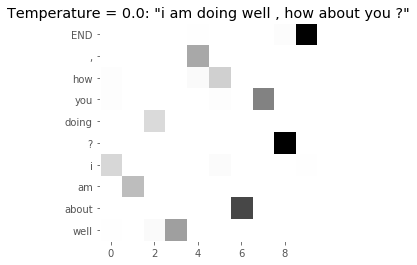

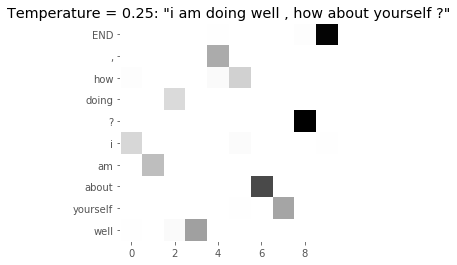

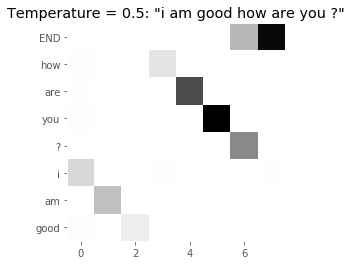

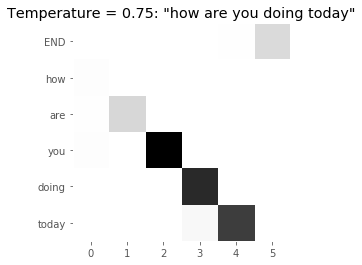

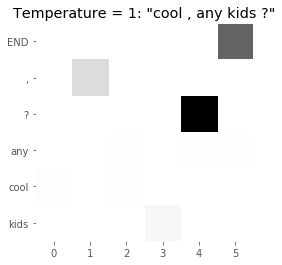

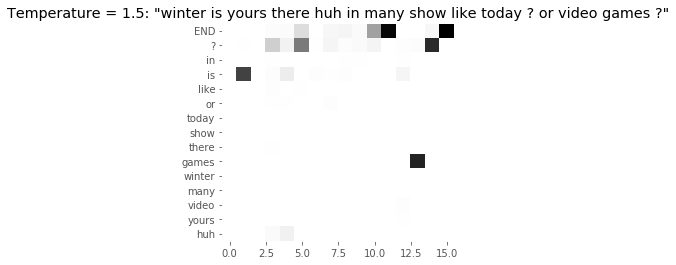

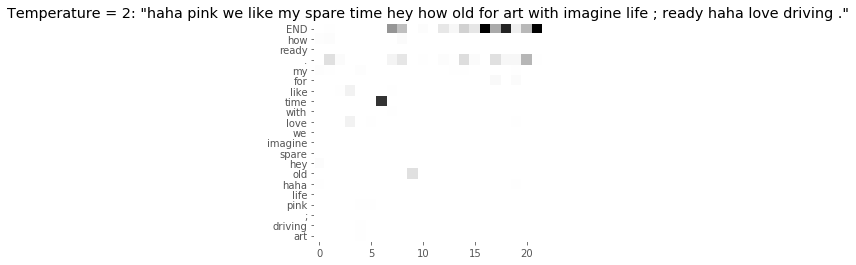

In [50]:
for i, t in enumerate(temperatures):
    plot_distrs(*generated_sentences[i], t)

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer** We notice many clusters based upon role in language. Specifically, we notice a cluster of with 'and', 'or', 'but', 'because', which all represent conjunctions to join clauses. This cluster is near the cluster of '.', '!' and '?' which are all terminating punctuations, and play a similar role to the conjunctions because they both occur at the end of clauses. We also note a cluster of 'can', 'could', 'will', 'would' and 'should', which all auxiliary verbs and occur in similar places in English.

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer** We want interchangeable words to have similar vector representations so that they are processed similarly as inputs to the model. In terms of generalization, models that treat similar words as similar vectors will be equipped to encounter new sentences where similar words (such as 'would' and 'should') are interchanged without needing to see a direct example of that sentence in training. For generation of new sentences similar words will be modeled as similar vector inputs, which will output similar transition probabilities. This will help the model to create novel productions. (for example: "I would" should be able to produce similar sentences as "I should")

In [75]:
# Selecting the top 200 words for count
top_200_words = dictionary.most_common(200)
l = [i[0] for i in top_200_words]
batches = [l[i:i + 24] for i in range(0, len(l), 24)]

# Creating batches for feeding the model
batches_token = [[tokens.index(word) for word in batch] for batch in batches]
batches_padded = pad_sequences(batches_token, maxlen-1, padding="post", truncating="post")

In [76]:
# Building the simple model
input_l = Input(shape=(maxlen-1,), name="input")  
emb_l = Embedding(len(tokens), embedding_size, embeddings_initializer=keras.initializers.Constant(np.load("best_embedding_2.npy")[0]), mask_zero=True, name="embedding", trainable=False)(input_l)

model_emb = Model(inputs = [input_l], outputs = [emb_l])

In [77]:
# Selecting embeddings without padding
model_emb_prediction = model_emb.predict(np.array(batches_padded))
embeddings = [i for e in model_emb_prediction for i in e][:200]

In [78]:
# Use t-SNE dimensionality reduction to project the embeddings

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

embs = tsne.fit_transform(embeddings)

# Get values for x and y coordinates
x_values = embs[:, 0]
y_values = embs[:, 1]

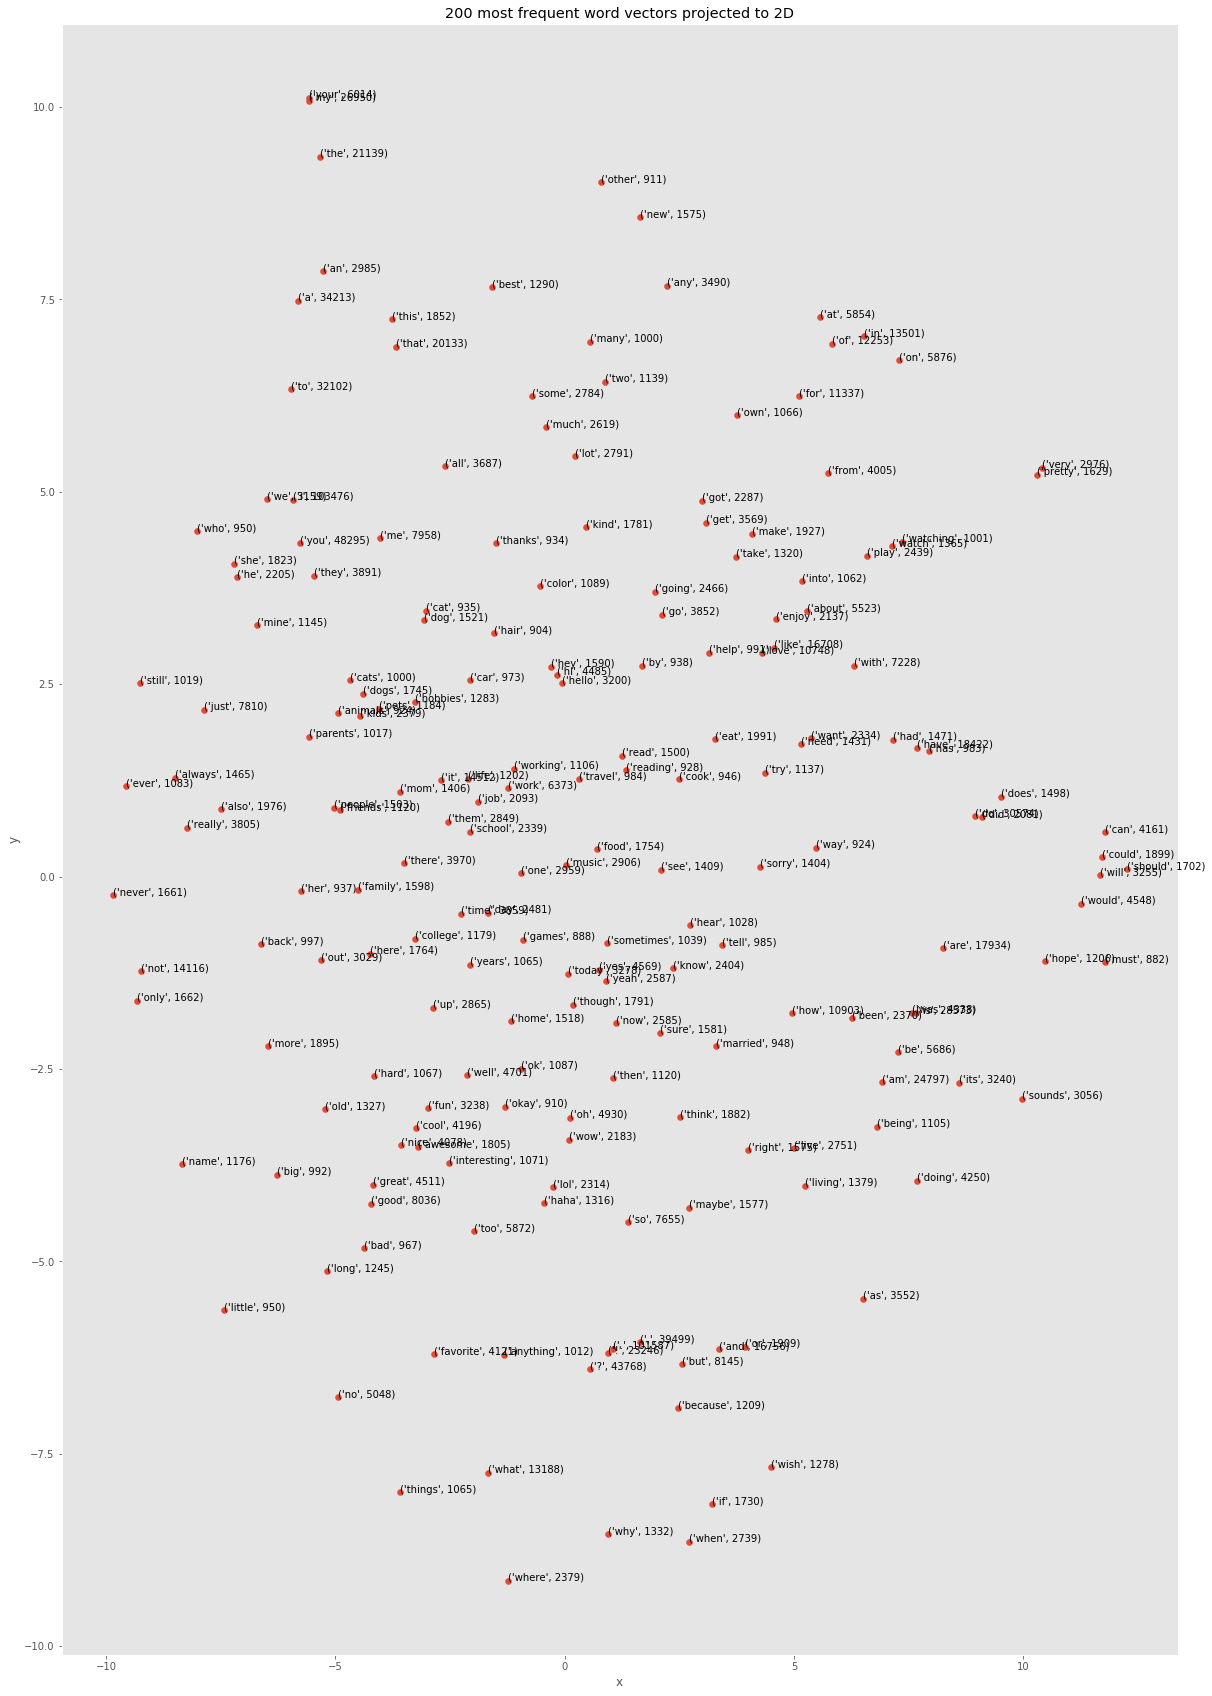

In [98]:
# Plot with labels

plt.figure(figsize=(20,30))
plt.title("200 most frequent word vectors projected to 2D")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x_values, y_values)
for label, x, y in zip(top_200_words, x_values, y_values):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer** The generated answers are not very similar to the real ones in most cases. However, in some cases it provides answers that are sensible to the question, especially considering the types of dialogue in the training set. A good example is:

Actual Sentence: how are you doing today

Actual Response: hi ! i am good , just finished playing basketball . i love it .

Prediction t=0.5: i am doing well , how are you ?

Prediction t=1: i am well i enjoying the news

In this case, our generated answers seemed more in line with a realistic conversation than the actual response was. A bad example is:

Actual Sentence: i meant the doctor said that i only have six months left

Actual Response: oh no . what is wrong with you ?

Prediction t=0.5: do you have any pets ? i am a fan of them .

Prediction t=1: i have not been working

In this case, both answers did not deal very well with the initial sentence and sent back 'generically probable' answers (sentences that common overall in the data, without regard to the previous sentence)

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer** In our case, we felt that 0.5 was giving more reasonable answers than 1.0. Both temperatures had a tendency to undervalue the context of the preceding sentence when formulating the response, but with lower temperatures the resulting response followed grammatical rules with much higher probability. Sampling at 1.0 or higher often produces answers that do not follow English grammar.

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer** No. For a generative model, we want to produce language that is similar to but not exactly like the examples of the language from which the model is trained. If we were interested in producing exact responses learned from training, we could simply keep a "Sentence:Response" dictionary and save ourselves the trouble of training a model. Furthermore, our model's ability to generalize is dependent upon the fact that it doesn't memorize the training data exactly.

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [63]:
## Make call/response pairs
def make_pairs(conv, vocab=tokens):
    calls = conv[:-1]
    responses = conv[1:]
    
    ## Make pairs only if both the 'call' and 'response' are composed entirely of words in vocabulary
    pairs = [list(i) for i in zip(calls,responses) 
             if all([w in tokens for w in i[0].split(' ')]) and all([w in tokens for w in i[1].split(' ')])]
    return pairs

## Take all pairs of dialogue in each conversation
convs_pairs = [make_pairs(conv) for conv in conversations if len(conv)>1]
## Flatten to has only a list of pairs
pairs = [exchange for c in convs_pairs for exchange in c]

In [64]:
## Tokenize, padd and truncate each part of the pairs
calls = [[tokens.index(w) for w in i[0].split(' ')] for i in pairs]
calls = np.array(pad_sequences(calls, maxlen=maxlen-2))
responses = [[tokens.index(w) for w in ['START']+i[1].split(' ')+['END']] for i in pairs]
responses = np.array(pad_sequences(responses, maxlen=maxlen, padding='post', truncating='post'))

## Create input X and target T for training
X = [calls, responses[:,:-1]]
T = np.zeros(X[1].shape + (len(tokens),))
for i, sentence in enumerate(responses[:,1:]):
    for j, word in enumerate(sentence):
        T[i,j,word] = 1
X[0].shape, X[1].shape, T.shape

((19749, 23), (19749, 24), (19749, 24, 1010))

In [66]:
# Using best embedding
best_embedding = Embedding(len(tokens), embedding_size, embeddings_initializer=keras.initializers.Constant(np.load("best_embedding_2.npy")[0]), mask_zero=True, name="embedding", trainable=False)

In [67]:
# Building model
context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = best_embedding
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
decoder2 = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 24)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 23)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             129280      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  49408       embedding[0][0]                  
__________

In [68]:
## Train model with Early Stopping
es = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)

chatbot = Chatbot.fit(X, T, epochs=epochs, validation_split=validation_split, batch_size=batch_size, callbacks=[es]).history

Train on 15799 samples, validate on 3950 samples
Epoch 1/32
15799/15799 [==============================] - 20s 1ms/step - loss: 4.3881 - acc: 0.2321 - val_loss: 3.5736 - val_acc: 0.3342
Epoch 2/32
15799/15799 [==============================] - 19s 1ms/step - loss: 3.3477 - acc: 0.3575 - val_loss: 3.1825 - val_acc: 0.3762
Epoch 3/32
15799/15799 [==============================] - 20s 1ms/step - loss: 3.0947 - acc: 0.3823 - val_loss: 3.0271 - val_acc: 0.3926
Epoch 4/32
15799/15799 [==============================] - 19s 1ms/step - loss: 2.9625 - acc: 0.3943 - val_loss: 2.9342 - val_acc: 0.4020
Epoch 5/32
15799/15799 [==============================] - 20s 1ms/step - loss: 2.8732 - acc: 0.4021 - val_loss: 2.8744 - val_acc: 0.4077
Epoch 6/32
15799/15799 [==============================] - 19s 1ms/step - loss: 2.8069 - acc: 0.4090 - val_loss: 2.8327 - val_acc: 0.4127
Epoch 7/32
15799/15799 [==============================] - 20s 1ms/step - loss: 2.7570 - acc: 0.4147 - val_loss: 2.7979 - val_acc:

In [71]:
## Helper to predict output as a String the response
def as_string(lst):
    return ' '.join([i for i in lst if i!='START' and i!='END' and i!='PADD'])

## Helper to predict the next word
def predict_next_with_context(prefix, model, context, sampler, dictionary=tokens, maxlen=maxlen):
    '''Produces the next word after a given subsentence and a given context, using a model and a sampling function.
    Arguments:
    prefix - (str) sentence of words used so far
    model - (keras.Model) RNN that can make predictions
    context - (list) encoded context of preceding sentence (caller's sentence in call/response)
    sampler - (function) function to sample 
    Returns:
    (str) next word predicted
    (np.ndarray) array of transition probabilities next word was selected from
    '''
    words = prefix.split(" ")
    input_tokens = np.zeros((1, maxlen-1))
    for i in range(len(words)):
        input_tokens[0,i] = tokens.index(words[i])
    preds = model.predict([context, input_tokens])
    next_distr = preds[0, len(words)-1]
    next_index = sampler(next_distr)
    return tokens[next_index], next_distr

def predict_response(call, model, temperature, maxlen=maxlen, verbose=0):
    '''Produces an entire sentence generated by the Chatbot model
    Arguments:
    call - (string) the 'calling' sentence which is used to generate the context in the model
    model - (keras.Model) RNN used to generate predictions
    temperature - (double) sampling temperature
    Returns:
    (list) list of all words in the sentence
    (list) list of transition probabilities from which sentence was generated
    '''
    call = call.split(' ')
    call = [tokens.index(word) for word in call]
    call = np.array(pad_sequences([call], maxlen-2, padding='pre', truncating='pre'))
    sampler = lambda x: sample(x, temperature=temperature)
    sentence = ["START"]
    distrs = []
    while len(sentence) < maxlen and sentence[-1]!='END':
        prefix = ' '.join(sentence)
        next_word, next_distr = predict_next_with_context(prefix, model, call, sampler)
        sentence.append(next_word)
        distrs.append(next_distr)
        if verbose==2 and sentence[-1]!='END':
            print(' '.join([i for i in sentence if i!='START' and i!='END' and i!='PADD']))
    if verbose==1:
        print(' '.join([i for i in sentence if i!='START' and i!='END' and i!='PADD']))
    return sentence, distrs

In [72]:
# Comparing predicted response to real answers for 10 sample pairs and two levels of temperature
samples = random.sample(pairs, 10)
predictions = [(s[0], 
                s[1], 
                as_string(predict_response(s[0], Chatbot, 0.5)[0]), 
                as_string(predict_response(s[0], Chatbot, 1)[0])) 
               for s in samples]
for i in predictions:
    print("Actual Sentence: {0}\n  Actual Response:  {1}\n  Prediction t=0.5:  {2}\n  Prediction t=1:  {3}".format(*i))

Actual Sentence: i meant the doctor said that i only have six months left
  Actual Response:  oh no . what is wrong with you ?
  Prediction t=0.5:  do you have any pets ? i am a fan of them .
  Prediction t=1:  i have not been working
Actual Sentence: no i drink just water .
  Actual Response:  i like water too , sometimes . do you have a job ?
  Prediction t=0.5:  i am single . i have not seen a lot of time with my dad .
  Prediction t=1:  who is not ? tell me more a boy
Actual Sentence: how long have you lived on a farm
  Actual Response:  i just volunteer there . i live in an apartment .
  Prediction t=0.5:  i will get to the it soon .
  Prediction t=1:  that was it from myself
Actual Sentence: i am well . do you have any favorite shows ?
  Actual Response:  i like christmas movies like white christmas .
  Prediction t=0.5:  i like to play sports and two cats .
  Prediction t=1:  mostly i am in meat and eat . you ?
Actual Sentence: oh ok . what do you do for fun
  Actual Response:  

In [25]:
def repl(temperature=1):
    print("You:", end = ' ')
    x = input()
    while x!="quit":
        call = (''.join([' ' + i + ' ' if i in ",.?!" else i for i in x.lower()])).split()
        call = ' '.join([i for i in call if i in tokens])
        if len(call)==0:
            call = 'PADD'
        prediction = predict_response(call, Chatbot, temperature)[0]
        bot_output = as_string(prediction)
        print("CzatBaut:", bot_output)
        print("You:", end = ' ')
        x = input()

In [38]:
# Playing with the Chatbot
repl(0.5)

You: hi
CzatBaut: hello , how are you ?
You: how are you?
CzatBaut: i am doing well , just working on a long break .
You: are you a vegan?
CzatBaut: i am a teacher . i love people .
You: What is your favorite color?
CzatBaut: my favorite color is pink .
You: What is your favorite food?
CzatBaut: i love meat , i like it . i love to travel
You: What is your favorite book?
CzatBaut: i like to cook and listen to music
You: Do you like books?
CzatBaut: i do , but i am a teacher
You: i am spending time with my 4 sisters what are you up to
CzatBaut: i am done with my mom .
You: anyway . what do you do ?
CzatBaut: i like to cook and i love to read .
You: do you travel ?
CzatBaut: yes . i like to read mostly .
You: quit
